# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
sns.set_style('whitegrid', {'grid.linestyle': '--', 'grid.color': '.8'})

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). 

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# подберем параметр С через кросс-валидацию на основании сетки, подобранной на субъективный взгляд
parameters = {'C': [0.00001, 0.001, 0.01, 0.02, 0.03, 0.1, 0.4, 1, 2, 5]} 

grid_classifier = SVC(kernel='linear')
grid_classifier = GridSearchCV(grid_classifier, parameters, cv=5, n_jobs=-1)
grid_classifier.fit(X_train, y_train)

print('Лучший параметр C - {} с результатом R^2 - {}'.format(grid_classifier.best_params_['C'],
                                                             grid_classifier.best_score_))

Лучший параметр C - 0.02 с результатом R^2 - 0.7817142857142858


На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью `sklearn` можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты. 

In [4]:
# обучим модель
classifier = SVC(kernel='linear', C=grid_classifier.best_params_['C'], probability=True)
classifier.fit(X_train, y_train)
y_predict = classifier.predict_proba(X_test)[:, 1]

Построим сначала графики, а потом посчитаем площадь под ними. 

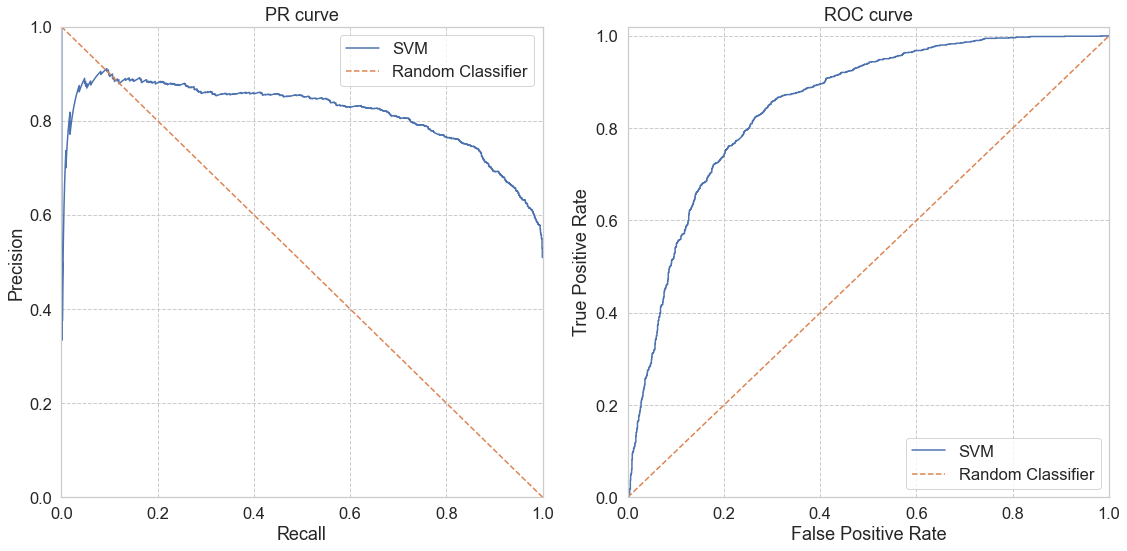

In [5]:
from sklearn.metrics import average_precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve

# Вдохновение - https://habr.com/ru/company/ods/blog/328372/

plt.figure(figsize=(16, 8))

plt.subplot(121)
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
plt.plot(recall, precision, lw = 1.5, label='PR curve')
plt.plot([1, 0], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(['SVM', 'Random Classifier'])

AUC_PR = auc(recall, precision)

plt.subplot(122)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
plt.plot(fpr, tpr, lw=1.5, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(['SVM', 'Random Classifier'])

AUC_ROC = auc(fpr, tpr)

plt.tight_layout()
plt.show()

Посчитаем площадь под кривыми.

In [6]:
print('Вариант 1:')
print('AUC-PR - {}'.format(round(AUC_PR, 5)))
print('AUC-ROC - {}'.format(round(AUC_ROC, 5)))

print('Вариант 2:')
print('AUC-PR - {}'.format(round(average_precision_score(y_test, y_predict), 5)))
print('AUC-ROC - {}'.format(round(roc_auc_score(y_test, y_predict), 5)))

Вариант 1:
AUC-PR - 0.81498
AUC-ROC - 0.84789
Вариант 2:
AUC-PR - 0.81537
AUC-ROC - 0.84789


В варианте 1 площадь под кривой рассчитается с использованием правила трапеции, когда в варианте 2 площадь рассчитывается на основании оценок прогнозов, для PR площадь под кривой рассчитывается как средневзвешенное значение precision, достигнутой на каждом threshold, с увеличением recall по сравнению с предыдущим threshold.

Следует заметить, что при вычислении площади при помощи метода `auc` используются вероятности, когда для методов `roc_auc_score` и `average_precision_score` (в чистом виде) используются прогнозные значения 0 и 1. Учитывая это площадь под кривой с использованием этих методов получается меньше. Поэтому для второго варианта также использованы значения `predict_proba`, которые дают только небольшую погрешность для AUC-PR.

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [7]:
from sklearn.linear_model import LogisticRegression

# напомним, что параметр С подбирается по следующей сетке
parameters = {'C': [0.00001, 0.001, 0.01, 0.02, 0.03, 0.1, 0.4, 1, 2, 5]} 

grid_classifier_log = LogisticRegression(penalty='l2')
grid_classifier_log = GridSearchCV(grid_classifier_log, parameters, cv=5, n_jobs=-1) 
grid_classifier_log.fit(X_train, y_train)

print('Лучший параметр C - {} с результатом R^2 - {}'.format(grid_classifier_log.best_params_['C'],
                                                             grid_classifier_log.best_score_))

Лучший параметр C - 0.01 с результатом R^2 - 0.7801428571428571


In [8]:
# обучим модель
classifier_log = LogisticRegression(penalty='l2', C=grid_classifier_log.best_params_['C'])
classifier_log.fit(X_train, y_train)
y_predict_log = classifier_log.predict_proba(X_test)[:,1]

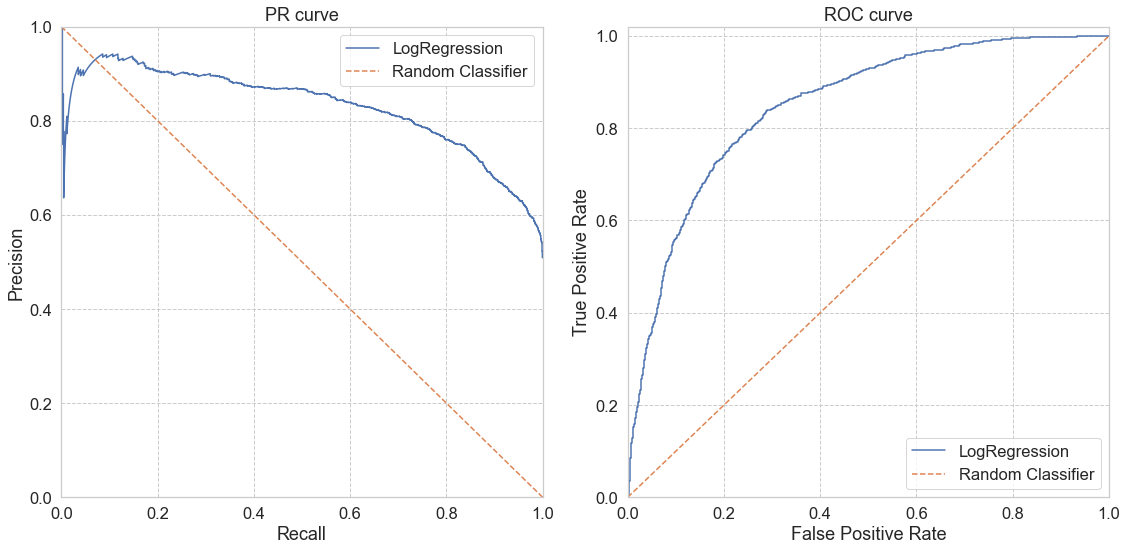

In [9]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
precision, recall, thresholds = precision_recall_curve(y_test, y_predict_log)
plt.plot(recall, precision, lw = 1.5, label='PR curve')
plt.plot([1, 0], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(['LogRegression', 'Random Classifier'])

AUC_PR_log = auc(recall, precision)

plt.subplot(122)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_log)
plt.plot(fpr, tpr, lw=1.5, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(['LogRegression', 'Random Classifier'])

AUC_ROC_log = auc(fpr, tpr)

plt.tight_layout()
plt.show()

In [10]:
print('Вариант 1:')
print('AUC-PR - {}'.format(round(AUC_PR_log, 5)))
print('AUC-ROC - {}'.format(round(AUC_ROC_log, 5)))

print('Вариант 2:')
print('AUC-PR - {}'.format(round(average_precision_score(y_test, y_predict_log), 5)))
print('AUC-ROC - {}'.format(round(roc_auc_score(y_test, y_predict_log), 5)))

Вариант 1:
AUC-PR - 0.82968
AUC-ROC - 0.84759
Вариант 2:
AUC-PR - 0.82993
AUC-ROC - 0.84759


Выводы для результатов аналогичны приведенным ранее. 

Сравнение результатов SVM и LogisticRegression:

In [11]:
print('SVM')

print('Вариант 1:')
print('AUC-PR - {}'.format(round(AUC_PR, 5)))
print('AUC-ROC - {}'.format(round(AUC_ROC, 5)))

print('Вариант 2:')
print('AUC-PR - {}'.format(round(average_precision_score(y_test, y_predict), 5)))
print('AUC-ROC - {}'.format(round(roc_auc_score(y_test, y_predict), 5)))

print('--------------------')

print('LogisticRegression')

print('Вариант 1:')
print('AUC-PR - {}'.format(round(AUC_PR_log, 5)))
print('AUC-ROC - {}'.format(round(AUC_ROC_log, 5)))

print('Вариант 2:')
print('AUC-PR - {}'.format(round(average_precision_score(y_test, y_predict_log), 5)))
print('AUC-ROC - {}'.format(round(roc_auc_score(y_test, y_predict_log), 5)))

SVM
Вариант 1:
AUC-PR - 0.81498
AUC-ROC - 0.84789
Вариант 2:
AUC-PR - 0.81537
AUC-ROC - 0.84789
--------------------
LogisticRegression
Вариант 1:
AUC-PR - 0.82968
AUC-ROC - 0.84759
Вариант 2:
AUC-PR - 0.82993
AUC-ROC - 0.84759


SVM и LogisticRegression показывают почти одинаковые результаты на метрике AUC-ROC, однако на метрике AUC-PR LogisticRegression показывает результат лучше. Данные результаты тяжело интерпретировать, поскольку в теории SVM должен показывать результаты лучше, чем LogisticRegression. Это связано с тем, что SVM пытается найти максимально возможную разделяющую границу, в то время как LogisticRegression оптимизирует функцию логарифмического правдоподобия с вероятностями, моделируемыми сигмоидальной функцией. При этом SVM лучше справляется с выбросами, чем LogisticRegression.

Обратную ситуацию можно объяснить тем, что параметр регуляризации $C$ для LogisticRegression подобран лучше, чем для SVM. Оттуда и обратный результат.
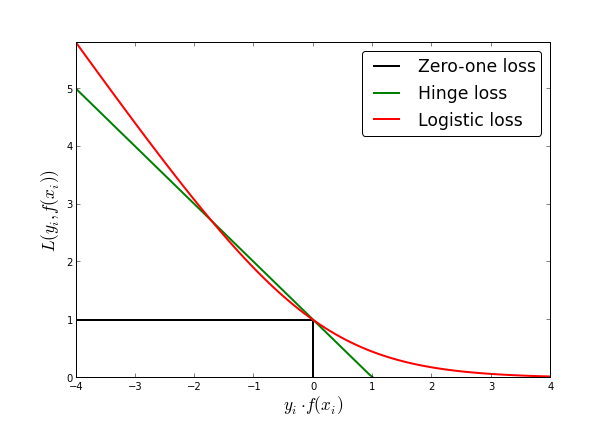

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [12]:
# Не будем генерировать слишком большой датасет, иначе график получится перегруженным
X1, y1 = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=78)

# подберем параметр С 
parameters = {'C': [0.00001, 0.001, 0.01, 0.02, 0.03, 0.1, 0.4, 1, 2, 5]} 

grid_classifier = SVC(kernel='linear')
grid_classifier = GridSearchCV(grid_classifier, parameters, cv=5, n_jobs=-1)
grid_classifier.fit(X1, y1)

print('Лучший параметр C - {} с результатом R^2 - {}'.format(grid_classifier.best_params_['C'],
                                                             grid_classifier.best_score_))

Лучший параметр C - 0.01 с результатом R^2 - 0.901


Обучим модель с лучшим параметром.

In [13]:
classifier = SVC(kernel='linear', C=grid_classifier.best_params_['C'], probability=True)
classifier.fit(X1, y1)

SVC(C=0.01, kernel='linear', probability=True)

Введем функцию, которая поможет с построением сетки.

In [14]:
# https://github.com/esokolov/ml-course-hse/blob/master/2018-fall/seminars/sem07-trees.ipynb
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

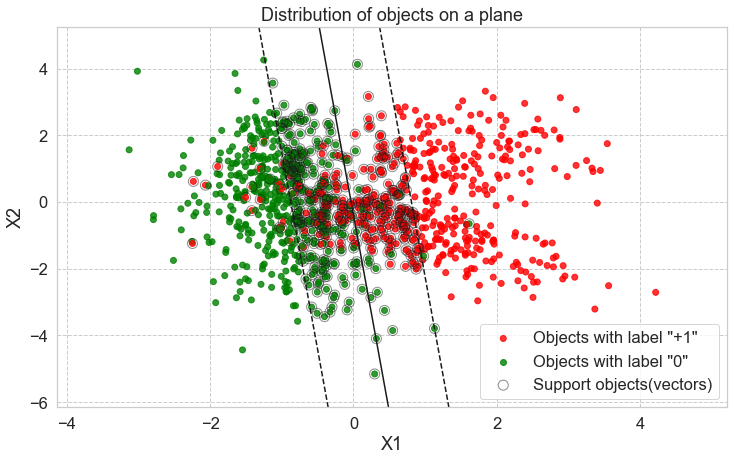

In [15]:
# https://codengineering.ru/post/23198

fig, ax = plt.subplots(figsize=(12, 7))

# Создание сетки для оценки модели
XX, YY = get_grid(X1)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# Присвоение классам различных цветов
colors = np.where(y1 == 1, 'red', 'green')

# Отобразим данные на графике
ax.scatter(X1[:,0], X1[:,1], c=colors, alpha=0.8, label='Objects with label "+1"')

# Небольшой костыль, отрисуем заново один объект, чтобы присвоить зеленому классу лейбл
ax.scatter(X1[2,0], X1[2,1], c='green', alpha=0.8, label='Objects with label "0"')

# Разделяющая гиперплоскость
Z = classifier.decision_function(xy).reshape(XX.shape)

# Отображение разделяющей гиперплоскости
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], color = 'black', linestyles=['--', '-', '--'])

# Выделение опорных векторов окружностями
ax.scatter(classifier.support_vectors_[:, 0], classifier.support_vectors_[:, 1], s=100, 
           linewidth=1, facecolors='none', edgecolors='k', alpha = 0.5, label='Support objects(vectors)')

plt.title('Distribution of objects on a plane')
plt.xlabel('X1')
plt.ylabel('X2')

plt.legend()
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость, а приближает в каждой точке пространства объектов правдоподобие положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [16]:
grid_classifier_log = LogisticRegression(penalty='l2')
grid_classifier_log = GridSearchCV(grid_classifier_log, parameters, cv=5, n_jobs=-1) 
grid_classifier_log.fit(X1, y1)

print('Лучший параметр C - {} с результатом R^2 - {}'.format(grid_classifier_log.best_params_['C'],
                                                             grid_classifier_log.best_score_))

Лучший параметр C - 0.02 с результатом R^2 - 0.9010000000000001


In [17]:
classifier_log = LogisticRegression(penalty='l2', C=grid_classifier_log.best_params_['C'])
classifier_log.fit(X1, y1)

LogisticRegression(C=0.02)

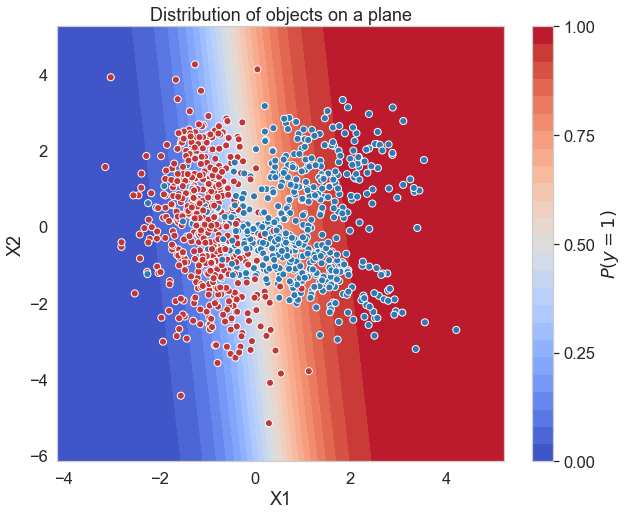

In [18]:
# Создание сетки для оценки модели
XX1, YY1 = get_grid(X1)
grid = np.c_[XX.ravel(), YY.ravel()]
probs = classifier_log.predict_proba(grid)[:, 1].reshape(XX.shape)

# https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression

f, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(XX, YY, probs, 30, cmap="coolwarm", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X1[:,0], X1[:, 1], c=y1, s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)
plt.title('Distribution of objects on a plane')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [17]:
# Модернизируем функцию так, чтобы при ее вызове можно было построить две кривые на одной плоскости
def plot_calibration_curve(y_test, prob_plot1, prob_plot2, label1, label2, title):
    bin_middle_points = []
    bin_real_ratios_1 = []
    bin_real_ratios_2 = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios_1.append(np.mean(y_test[(prob_plot1 >= l) & (prob_plot1 < r)] == 1)) 
        bin_real_ratios_2.append(np.mean(y_test[(prob_plot2 >= l) & (prob_plot2 < r)] == 1)) 
    plt.figure(figsize=(8,8))    
    plt.plot(bin_middle_points, bin_real_ratios_1, color='r', label=label1)
    plt.plot(bin_middle_points, bin_real_ratios_2, color='b', label=label2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='g', label = 'Best possible callibration curve')
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Centers of segments')
    plt.ylabel('Fractions of positives')
    plt.legend()
    plt.title('{} Calibration Curves'.format(title))

Сгенерируйте синтетический датасет аналогично использованному в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [18]:
X2, y2 = make_classification(n_samples=10000, n_features=20, n_informative=10, n_redundant=10, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

Гиперпарамет $C$ подбирать не будем, возьмем стандартный (перед нами такой задачи не стоит). Для корректного отображения калибровочной кривой необходимо воспользоваться `sigmoid` функцией, а также методом `decision_function`. При этом в SVC параметр `probability` установить равным *False*. В противном случае калибровочные кривые будут уже откалиброванными, то есть в следующем задании будет уже нечего калибровать.

In [19]:
def sigma(x):
    s = 1 / (1 + np.exp(-x))
    return s

In [20]:
SVM_classifier = SVC(kernel='linear', probability=False)
SVM_classifier.fit(X_train2, y_train2)
SVM_preds = sigma(SVM_classifier.decision_function(X_test2))

In [21]:
LOG_classifier = LogisticRegression(penalty='l2')
LOG_classifier.fit(X_train2, y_train2)
LOG_preds = sigma(LOG_classifier.decision_function(X_test2))

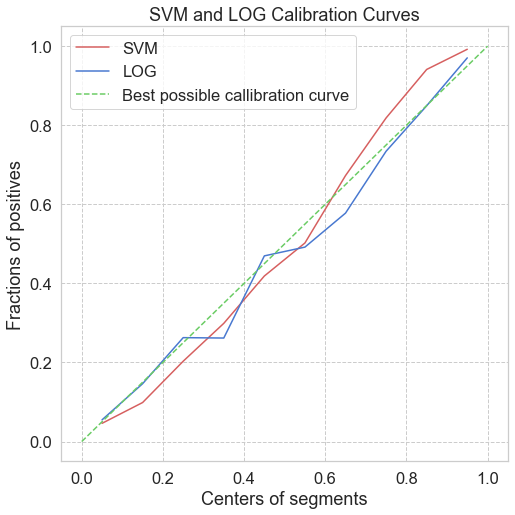

In [22]:
plot_calibration_curve(y_test2, SVM_preds, LOG_preds, 'SVM', 'LOG', 'SVM and LOG')

Построим гистограммы распределения ответов классификаторов.

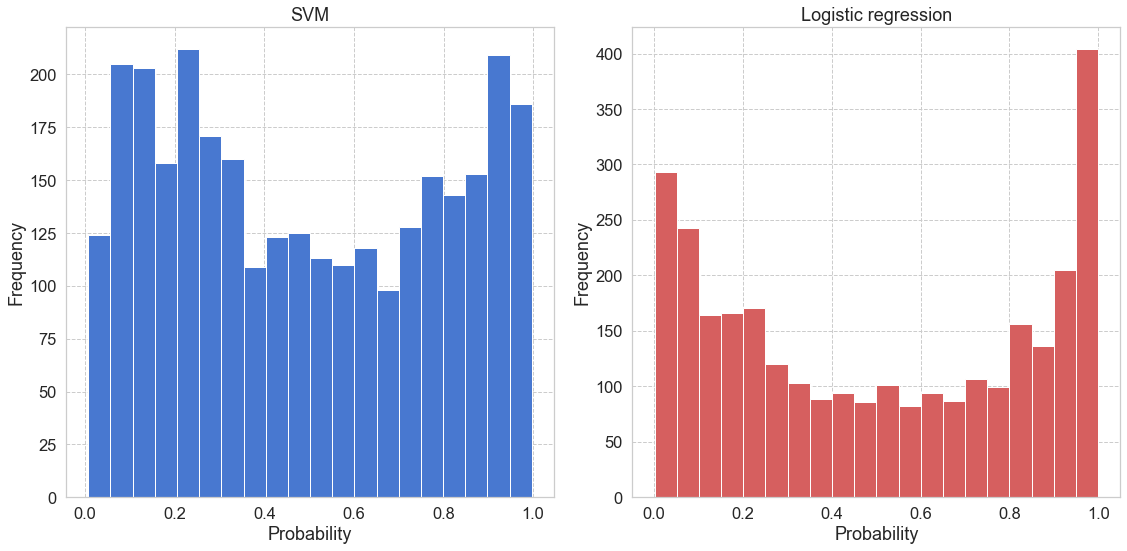

In [23]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.hist(SVM_preds, color='b', bins=20)
plt.title('SVM')
plt.ylabel('Frequency')
plt.xlabel('Probability')

plt.subplot(122)
plt.hist(LOG_preds, color='r', bins=20)
plt.title('Logistic regression')
plt.ylabel('Frequency')
plt.xlabel('Probability')

plt.tight_layout()
plt.show()

Как можно заметить, графики имеют некоторые общие черты, то есть наблюдается большое количество значений около нуля и единицы. Однако для графика `SVM` это распределение не так явно выражено, как на графике `Logistic regression`. Если посмотреть на график калибровочной кривой, то видно, что `Logistic regression` вначале и в конце очень близко находится к идеальной калибровочной кривой (`Logistic regression` не требует калибровки, в чем мы убедимся далее), тогда как `SVM` находится на этих промежутках не так близко к идеальной калибровочной кривой. Учитывая это, можно предположить, что чем ближе график калибровочной кривой к идеальному значению, тем больше значение `Frequency` на данных гистограммах. Давайте проверим данную гипотезу путем построения этих гистограмм после калибровки.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [24]:
from sklearn.calibration import CalibratedClassifierCV

log_calibration = CalibratedClassifierCV(LOG_classifier, cv=5)
log_calibration.fit(X_train2, y_train2)
LOG_predict_sk = log_calibration.predict_proba(X_test2)
LOG_preds_calibrated = LOG_predict_sk[:, 1]

In [25]:
SVM_calibration = CalibratedClassifierCV(SVM_classifier, cv=5)
SVM_calibration.fit(X_train2, y_train2)
SVM_predict_sk = SVM_calibration.predict_proba(X_test2)
SVM_preds_calibrated = SVM_predict_sk[:, 1]

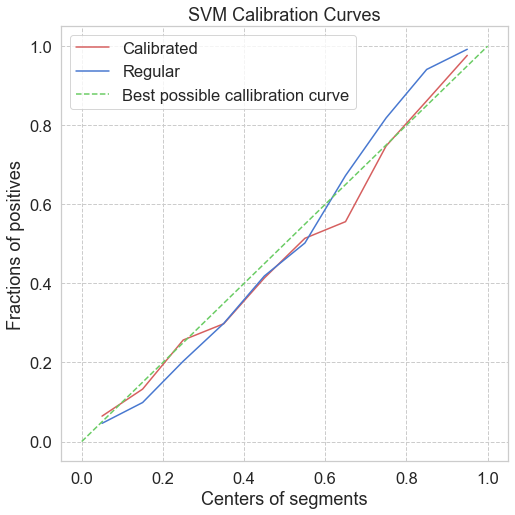

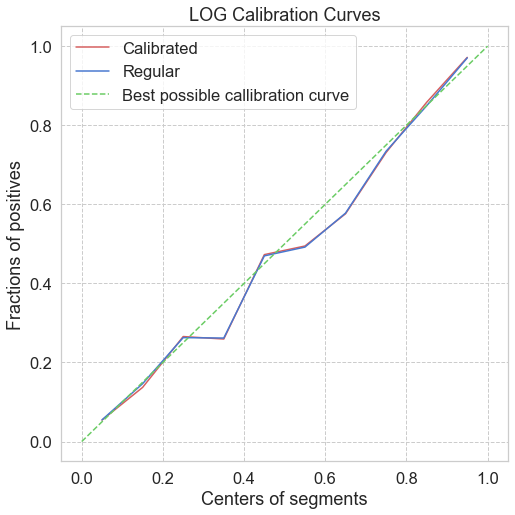

In [26]:
plot_calibration_curve(y_test2, SVM_preds_calibrated, SVM_preds, 'Calibrated', 'Regular', 'SVM')
plot_calibration_curve(y_test2, LOG_preds_calibrated, LOG_preds, 'Calibrated', 'Regular', 'LOG')

Проверим гипотезу

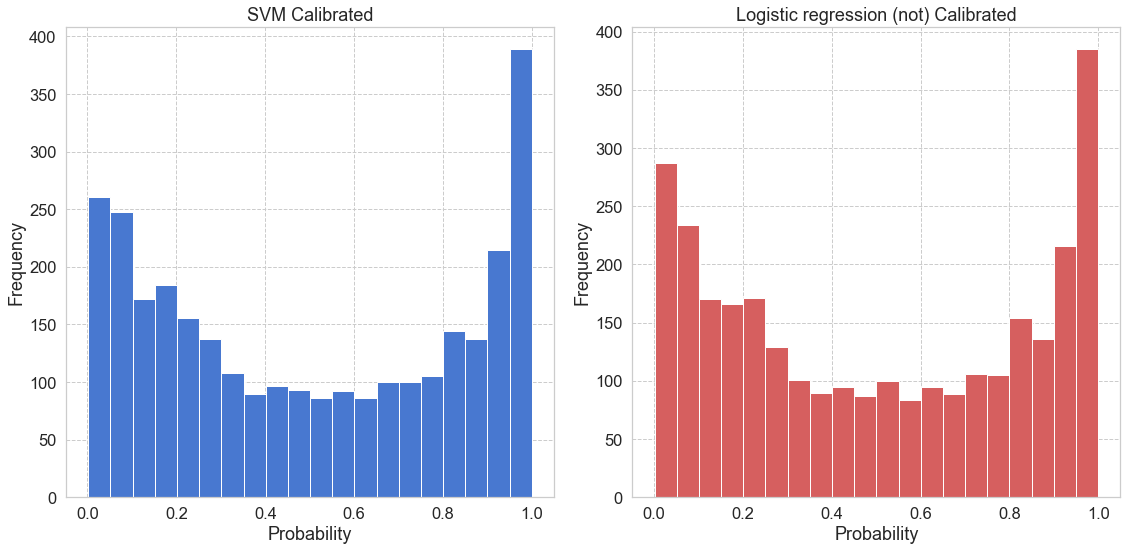

In [27]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.hist(SVM_preds_calibrated, color='b', bins=20)
plt.title('SVM Calibrated')
plt.ylabel('Frequency')
plt.xlabel('Probability')

plt.subplot(122)
plt.hist(LOG_preds_calibrated, color='r', bins=20)
plt.title("Logistic regression (not) Calibrated")
plt.ylabel('Frequency')
plt.xlabel('Probability')

plt.tight_layout()
plt.show()

Можно сделать вывод, что гипотеза верна. После калибровки графики выглядят почти идентично. График `Logistic regression` почти не изменился. **Вывод:** SVM без использования `probability` равного *True* нуждается в калибровке. 

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [28]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [29]:
# Если файл не скачан, то необходимо скачать файл 
# import wget
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
# wget.download(url)

import zipfile

zf = zipfile.ZipFile('bank-additional.zip')
df = pd.read_csv(zf.open('bank-additional/bank-additional-full.csv'), sep=';')

In [30]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



Для решения задачи не несет информации столбец `duration`, очевидно из описания признаков в .txt документе, что если продолжительность звонка уже известна, то мы уже звонили клиенту и знаем его ответ. Если наша цель определить согласиться ли клиент открыть депозит, то мы не можем заранее знать сколько продлиться телефонный звонок. Признак `duration` необходимо исключить.

In [31]:
df.drop(columns = ['duration'], inplace = True)
# сразу поменяем значение таргета на 0 и 1
df.y = df.y.apply(lambda x: 0 if x == 'no' else 1)

train_data, test_data = train_test_split(df, train_size=0.75, test_size=0.25, random_state=777, stratify=df.y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: В данных явно наблюдается дисбаланс классов, то есть положительно значение `yes` встречается намного реже, чем значение `no`. `AUC-ROC` устойчив к несбалансированным классам, когда `AUC-PR` сохраняет адекватность оценки при дисбалансе классов, хотя и является менее интерпретируемым. При очевидном дисбалансе классов либо надо прибегать к перегруппировке, в результате которой будет одинаковое количество положительный и отрицательных классов и использовать `AUC-ROC`, либо изначально пользоваться `AUC-PR`, что мы и будем делать.

In [32]:
print('+1 class count: {}'.format(len(df[df.y == 1])))
print('0 class count: {}'.format(len(df[df.y == 0])))

+1 class count: 4640
0 class count: 36548


In [33]:
from sklearn.preprocessing import OrdinalEncoder
import time

start = time.time()

categorial = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
              'contact', 'month', 'day_of_week', 'poutcome']

OrdEnc = OrdinalEncoder()

# Обучающая выборка
train_data_OrdEnc = pd.DataFrame(OrdEnc.fit_transform(train_data[categorial]), columns=[i for i in categorial])
train_data_OrdEnc.index = train_data.index
train_data_OrdEnc = pd.concat([train_data_OrdEnc, train_data.drop(categorial, axis=1)], axis=1)

X_train_OrdEnc = train_data_OrdEnc.drop(columns='y')
y_train_OrdEnc = train_data_OrdEnc.y

# Тестовая выборка
test_data_OrdEnc = pd.DataFrame(OrdEnc.transform(test_data[categorial]), columns=[i for i in categorial])
test_data_OrdEnc.index = test_data.index
test_data_OrdEnc = pd.concat([test_data_OrdEnc, test_data.drop(categorial, axis=1)], axis=1)

X_test_OrdEnc = test_data_OrdEnc.drop(columns='y')
y_test_OrdEnc = test_data_OrdEnc.y

# про параметры логистической регрессии ничего не было сказано, будем использовать стандартные
log = LogisticRegression(random_state=777)
log.fit(X_train_OrdEnc, y_train_OrdEnc)
prediction_OrdEnc = log.predict_proba(X_test_OrdEnc)[:,1]

time_OrdEnc = round((time.time() - start), 3)
AUC_PR_OrdEnc = round(average_precision_score(y_test_OrdEnc, prediction_OrdEnc), 5)

# Воспользуемся методом, который не требует построения графика
print('AUC-PR for OrdinalEncoder - {}'.format(AUC_PR_OrdEnc))
print('%s seconds for Logistic regression with OrdinalEncoder' % time_OrdEnc)

AUC-PR for OrdinalEncoder - 0.41593
0.497 seconds for Logistic regression with OrdinalEncoder


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

start = time.time()

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), categorial)])

# Обучающая выборка
train_data_OheEnc = column_transformer.fit_transform(train_data).toarray()
train_data_OheEnc = pd.DataFrame(train_data_OheEnc)
train_data_OheEnc.index = train_data.index
train_data_OheEnc = pd.concat([train_data_OheEnc, train_data.drop(categorial, axis=1)], axis=1)

X_train_OheEnc = train_data_OheEnc.drop(columns='y')
y_train_OheEnc = train_data_OheEnc.y

# Тестовая выборка
test_data_OheEnc = column_transformer.transform(test_data).toarray()
test_data_OheEnc = pd.DataFrame(test_data_OheEnc)
test_data_OheEnc.index = test_data.index
test_data_OheEnc = pd.concat([test_data_OheEnc, test_data.drop(categorial, axis=1)], axis=1)

X_test_OheEnc = test_data_OheEnc.drop(columns='y')
y_test_OheEnc = test_data_OheEnc.y

# про параметры логистической регрессии ничего не было сказано, будем использовать стандартные
log.fit(X_train_OheEnc, y_train_OheEnc)
prediction_OheEnc = log.predict_proba(X_test_OheEnc)[:,1]

time_OheEnc = round((time.time() - start), 3)
AUC_PR_OheEnc = round(average_precision_score(y_test_OheEnc, prediction_OheEnc), 5)

# Воспользуемся методом, который не требует построения графика
print('AUC-PR for OneHotEncoder - {}'.format(AUC_PR_OheEnc))
print('%s seconds for Logistic regression with OneHotEncoder' % time_OheEnc)
print('OneHotEncoder {} seconds slower than OrdinalEncoder, but AUC-PR better by {}'.format(
    round(time_OheEnc - time_OrdEnc, 3), round(AUC_PR_OheEnc - AUC_PR_OrdEnc, 3)))

AUC-PR for OneHotEncoder - 0.43542
0.764 seconds for Logistic regression with OneHotEncoder
OneHotEncoder 0.267 seconds slower than OrdinalEncoder, but AUC-PR better by 0.019


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


Поскольку **...все необходимые статистики нужно считать только по обучающей выборке...** относится к дополнительному заданию, то будем считать статистики для обучающей и тестовой выборки отдельно.

In [35]:
# Источники вдохновения для счетчиков:
# https://gist.github.com/marnixkoops/e68815d30474786e2b293682ed7cdb01
# https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

def counter(df, target, categorial):
    df_copy = df.copy()
    for j in categorial:
        lst = df_copy[j].unique()
        for i in lst:
            df_copy.loc[df_copy[j] == i, j] = np.mean(target[df_copy[j] == i])
    return df_copy

In [36]:
X_train = train_data.drop(columns='y')
y_train = train_data.y
X_test = test_data.drop(columns='y')
y_test = test_data.y

categorial = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
              'contact', 'month', 'day_of_week', 'poutcome']

start = time.time()

X_train_counter = counter(X_train, y_train, categorial)
X_test_counter = counter(X_test, y_test, categorial)

log = LogisticRegression(random_state=777)
log.fit(X_train_counter, y_train)
prediction_counter = log.predict_proba(X_test_counter)[:, 1]

time_counter = round((time.time() - start), 3)
AUC_PR_counter = round(average_precision_score(y_test, prediction_counter), 5)

print('AUC-PR for Counter - {}'.format(AUC_PR_counter))
print('%s seconds for Logistic regression with Counter' % time_counter)

AUC-PR for Counter - 0.41796
1.003 seconds for Logistic regression with Counter


Результаты очень похожи на результаты с использованием `OrdinalEncoder`, однако время больше, чем для `OneHotEncoder`.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [37]:
def counter_with_noise(df, categorial):
    df_copy = df.copy()
    for i in categorial:
        df_copy.loc[:,i] += np.random.normal(0, 1, len(df_copy[i]))
    return df_copy

In [38]:
start = time.time()

X_train_counter_noise = counter_with_noise(X_train_counter, categorial)
X_test_counter_noise = counter_with_noise(X_test_counter, categorial)

log.fit(X_train_counter_noise, y_train)
prediction_counter_noise = log.predict_proba(X_test_counter_noise)[:, 1]

time_counter_noise = round((time.time() - start), 3)
AUC_PR_counter_noise = round(average_precision_score(y_test, prediction_counter_noise), 5)

print('AUC-PR for Counter with Noise - {}'.format(AUC_PR_counter_noise))
print('%s seconds for Logistic regression with Counter with Noise' % time_counter_noise)

AUC-PR for Counter with Noise - 0.40937
0.375 seconds for Logistic regression with Counter with Noise


__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [39]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [40]:
def smoothed_counter(df, target, categorial, C):
    df_copy = df.copy()
    for j in categorial:
        lst = df_copy[j].unique()
        for i in lst:
            df_copy.loc[df_copy[j] == i, j] = (target[df_copy[j] == i].sum() + C * target.mean()) \
                                                    / (target[df_copy[j] == i].size + C)
    return df_copy

In [41]:
start = time.time()

X_train_smoothed_counter = smoothed_counter(X_train, y_train, categorial, 10)
X_test_smoothed_counter = smoothed_counter(X_test, y_test, categorial, 10)

log.fit(X_train_smoothed_counter, y_train)
prediction_smoothed_counter = log.predict_proba(X_test_smoothed_counter)[:, 1]

time_smoothed_counter = round((time.time() - start), 3)
AUC_PR_smoothed_counter = round(average_precision_score(y_test, prediction_smoothed_counter), 5)

print('AUC-PR for Smoothed Counter - {}'.format(AUC_PR_smoothed_counter))
print('%s seconds for Logistic regression with Smoothed Counter' % time_smoothed_counter)

AUC-PR for Smoothed Counter - 0.41788
1.955 seconds for Logistic regression with Smoothed Counter


In [42]:
start = time.time()

X_train_smoothed_counter_noise = counter_with_noise(X_train_smoothed_counter, categorial)
X_test_smoothed_counter_noise = counter_with_noise(X_test_smoothed_counter, categorial)

log.fit(X_train_smoothed_counter_noise, y_train)
prediction_smoothed_counter_noise = log.predict_proba(X_test_smoothed_counter_noise)[:, 1]

time_smoothed_counter_noise = round((time.time() - start), 3)
AUC_PR_smoothed_counter_noise = round(average_precision_score(y_test, prediction_smoothed_counter_noise), 5)

print('AUC-PR for Smoothed Counter with Noise - {}'.format(AUC_PR_smoothed_counter_noise))
print('%s seconds for Logistic regression with Smoothed Counter with Noise' % time_smoothed_counter_noise)

AUC-PR for Smoothed Counter with Noise - 0.41955
0.483 seconds for Logistic regression with Smoothed Counter with Noise


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [43]:
print('Number of unique values in age - {}'.format(df.age.nunique()))

Number of unique values in age - 78


In [44]:
categorial = ['age', 'job', 'marital', 'education', 'default', 'housing', 
              'loan', 'contact', 'month', 'day_of_week', 'poutcome']

start = time.time()

X_train_smoothed_counter_age = smoothed_counter(X_train, y_train, categorial, 10)
X_test_smoothed_counter_age = smoothed_counter(X_test, y_test, categorial, 10)

log.fit(X_train_smoothed_counter_age, y_train)
prediction_smoothed_counter_age = log.predict_proba(X_test_smoothed_counter_age)[:, 1]

time_smoothed_counter_age = round((time.time() - start), 3)
AUC_PR_smoothed_counter_age = round(average_precision_score(y_test, prediction_smoothed_counter_age), 5)

print('AUC-PR for Smoothed Counter and Age as counter - {}'.format(AUC_PR_smoothed_counter_age))
print('%s seconds for Logistic regression with Smoothed Counter and Age as counter' % time_smoothed_counter_age)

AUC-PR for Smoothed Counter and Age as counter - 0.42531
2.571 seconds for Logistic regression with Smoothed Counter and Age as counter


Результат стал немного лучше, однако и время на обучение модели также увеличилось. 

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [47]:
start = time.time()

# Обучающая выборка
X_train_month_day = X_train.copy()
X_train_month_day.month = pd.to_datetime(X_train.month, format='%b').dt.month
# Не очень красиво, но пока не придумал как по порядку дни недель красиво отсортировать. Да, костыль
X_train_month_day.day_of_week = X_train.day_of_week.apply(lambda x: 0 if x == 'mon' else (1 if x == 'tue' else \
                                                        (2 if x == 'wed' else (3 if x == 'thu' else 4))))

# Тестовая выборка
X_test_month_day = X_test.copy()
X_test_month_day.month = pd.to_datetime(X_test.month, format='%b').dt.month
X_test_month_day.day_of_week = X_test.day_of_week.apply(lambda x: 0 if x == 'mon' else (1 if x == 'tue' else \
                                                        (2 if x == 'wed' else (3 if x == 'thu' else 4))))

categorial = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

X_train_smoothed_counter_month_day = smoothed_counter(X_train_month_day, y_train, categorial, 10)
X_test_smoothed_counter_month_day = smoothed_counter(X_test_month_day, y_test, categorial, 10)

log.fit(X_train_smoothed_counter_month_day, y_train)
prediction_smoothed_counter_month_day = log.predict_proba(X_test_smoothed_counter_month_day)[:, 1]

time_smoothed_counter_month_day = round((time.time() - start), 3)
AUC_PR_smoothed_counter_month_day = round(average_precision_score(y_test, prediction_smoothed_counter_month_day), 5)

print('AUC-PR for Smoothed Counter and Month and Day of the week as non categorial features - {}' \
      .format(AUC_PR_smoothed_counter_month_day))
print('%s seconds for Logistic regression with Smoothed Counter and Month and Day of the week as non categorial features' \
      % time_smoothed_counter_month_day)

AUC-PR for Smoothed Counter and Month and Day of the week as non categorial features - 0.41333
0.976 seconds for Logistic regression with Smoothed Counter and Month and Day of the week as non categorial features


Обратный подход не дал ощутимых результатов. 

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Сначала отметим, что самым лучшим счетчиком оказался сглаженный счетчик (с возрастом в виде счетчика). Однако метрика качества данного счетчика все равно ниже OneHotEncoder. 

*Плюсы*: 
- количество признаков остается тем же, что и до кодирования 
- результат сопоставим с `OneHotEncoder`

*Минусы*: 
- сложнее в реализации, чем `OneHotEncoder` (отсутствует в scikit-learn)
- при вычислении **используются значения таргета**
- склонен к переобучению

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [45]:
df = pd.read_csv(zf.open('bank-additional/bank-additional-full.csv'), sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [46]:
categorial = ['job', 'marital', 'education', 'default', 'housing', 
              'loan', 'contact', 'month', 'day_of_week', 'poutcome']

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), categorial)])

# Обучающая выборка
X_train_enc = column_transformer.fit_transform(X_train).toarray()
X_train_enc = pd.DataFrame(X_train_enc)
X_train_enc.index = X_train.index
X_train_enc = pd.concat([X_train_enc, X_train.drop(categorial, axis=1)], axis=1)

# Тестовая выборка
X_test_enc = column_transformer.transform(X_test).toarray()
X_test_enc = pd.DataFrame(X_test_enc)
X_test_enc.index = X_test.index
X_test_enc = pd.concat([X_test_enc, X_test.drop(categorial, axis=1)], axis=1)

In [47]:
print('Number of features before OneHotEncoding - {}'.format(X_train.shape[1]))
print('Number of features after OneHotEncoding - {}'.format(X_train_enc.shape[1]))

Number of features before OneHotEncoding - 19
Number of features after OneHotEncoding - 62


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [48]:
log.fit(X_train_enc, y_train)
prediction_base = log.predict_proba(X_test_enc)[:,1]

AUC_PR_base = round(average_precision_score(y_test, prediction_base), 5)

print('Base AUC-PR - {}'.format(AUC_PR_base))

Base AUC-PR - 0.42971


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [49]:
top40 = np.abs(log.coef_).argsort()[0][-40:]

log.fit(X_train_enc.iloc[:, top40], y_train)
prediction_top40 = log.predict_proba(X_test_enc.iloc[:, top40])[:,1]
AUC_PR_top40 = round(average_precision_score(y_test, prediction_top40), 5)

print('top40 features AUC-PR - {}'.format(AUC_PR_top40))

top40 features AUC-PR - 0.44023


In [50]:
print('{} improvement in AUC-PR between top40 features and base score'.format(round(AUC_PR_top40-AUC_PR_base, 5)))

0.01052 improvement in AUC-PR between top40 features and base score


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

В нашей задаче неправильно будет пользоваться StandartScaler, поскольку сохранится некоторый разброс и значения каждого признака будут распределены разным образом. Давайте нормируем наши признаки на отрезке [0,1] при помощи MinMaxScaler

In [51]:
from sklearn.preprocessing import MinMaxScaler

column_transformer = ColumnTransformer([('minmax', MinMaxScaler(feature_range=(0, 1)), X_test_enc.columns)])

# Обучающая выборка
X_train_norm = column_transformer.fit_transform(X_train_enc)
X_train_norm = pd.DataFrame(X_train_norm)
X_train_norm.index = X_train_enc.index

# Тестовая выборка
X_test_norm = column_transformer.transform(X_test_enc)
X_test_norm = pd.DataFrame(X_test_norm)
X_test_norm.index = X_test_enc.index

In [52]:
log.fit(X_train_norm, y_train)
prediction_base_norm = log.predict_proba(X_test_norm)[:,1]

AUC_PR_base_norm = round(average_precision_score(y_test, prediction_base_norm), 5)

print('Base normed AUC-PR - {}'.format(AUC_PR_base_norm))

Base normed AUC-PR - 0.45028


In [53]:
top40_norm = np.abs(log.coef_).argsort()[0][-40:]

log.fit(X_train_norm.iloc[:, top40_norm], y_train)
prediction_top40_norm = log.predict_proba(X_test_norm.iloc[:, top40_norm])[:,1]
AUC_PR_top40_norm = round(average_precision_score(y_test, prediction_top40_norm), 5)

print('top40 normed features AUC-PR - {}'.format(AUC_PR_top40_norm))

top40 normed features AUC-PR - 0.44999


In [54]:
print('{} improvement in AUC-PR between base normed at [0, 1] and base score'.format(round(AUC_PR_base_norm-AUC_PR_base, 5)))
print('{} improvement in AUC-PR between top40 normed features and base normed score'.format(
    round(AUC_PR_top40_norm-AUC_PR_base_norm, 5)))

0.02057 improvement in AUC-PR between base normed at [0, 1] and base score
-0.00029 improvement in AUC-PR between top40 normed features and base normed score


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [55]:
from sklearn.preprocessing import Normalizer

column_transformer = ColumnTransformer([('norm', Normalizer(), X_train_norm.columns)])

# Обучающая выборка
X_train_norm_scaled = column_transformer.fit_transform(X_train_norm)
X_train_norm_scaled = pd.DataFrame(X_train_norm_scaled)
X_train_norm_scaled.index = X_train_norm.index
             
# Тестовая выборка
X_test_norm_scaled = column_transformer.transform(X_test_norm)
X_test_norm_scaled = pd.DataFrame(X_test_norm_scaled)
X_test_norm_scaled.index = X_test_norm.index

In [56]:
log.fit(X_train_norm_scaled, y_train)
prediction_base_norm_scaled = log.predict_proba(X_test_norm_scaled)[:,1]

AUC_PR_base_norm_scaled = round(average_precision_score(y_test, prediction_base_norm_scaled), 5)

print('Base normed and scaled AUC-PR - {}'.format(AUC_PR_base_norm_scaled))

Base normed and scaled AUC-PR - 0.45024


In [57]:
top40_norm_scaled = np.abs(log.coef_).argsort()[0][-40:]

log.fit(X_train_norm_scaled.iloc[:, top40_norm_scaled], y_train)
prediction_top40_norm_scaled = log.predict_proba(X_test_norm_scaled.iloc[:, top40_norm_scaled])[:,1]
AUC_PR_top40_norm_scaled = round(average_precision_score(y_test, prediction_top40_norm_scaled), 5)

print('top40 normed and scaled features AUC-PR - {}'.format(AUC_PR_top40_norm_scaled))

top40 normed and scaled features AUC-PR - 0.45028


In [58]:
if all(top40_norm == top40_norm_scaled):
    print('top40 Features are the Same')
else:
    print('top40 Features are Different')

print('{} downgrade in AUC-PR between base normed and scaled and base normed score'.format(
    round(AUC_PR_base_norm-AUC_PR_base_norm_scaled, 5)))
print('{} improvement in AUC-PR between top40 normed features and top40 normed and scaled features'.format(
    round(AUC_PR_top40_norm_scaled-AUC_PR_top40_norm, 5)))

top40 Features are Different
4e-05 downgrade in AUC-PR between base normed and scaled and base normed score
0.00029 improvement in AUC-PR between top40 normed features and top40 normed and scaled features


**Вывод:** самым лучшим показателем метрики AUC-PR является значение 0.45028. Данный результат удалось достичь на 40 лучших признаках после масштабирования данных на отрезке [0,1]  и нормирования данных. При этом AUC-PR на всех признаках при использовании такого масштабирования оказался лучше, чем базовый показатель. Также следует отметить, что нормировка после масштабирования не принесла существенных результатов, если на всех признаках метрика осталась практически идентичной, то на 40 лучших признаках показатель метрики совсем немного улучшился. 

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [59]:
def t_test(df, target):
    t_score = []
    for i in df.columns:
        mu_plus = df[i][target == 1].mean()
        mu_minus = df[i][target == 0].mean()
        n_plus = df[i][target == 1].size
        n_minus = df[i][target == 0].size
        sigma_plus = df[i][target == 1].std()
        sigma_minus = df[i][target == 0].std()
        t_i =                             np.abs(mu_plus - mu_minus) \
                      / np.sqrt((n_plus*np.square(sigma_plus)+n_minus*np.square(sigma_minus))\
                                             /(n_plus+n_minus))
        t_score.append(t_i)
    return t_score

Отбирать признаки будем на тестовой части. Воспользуемся данными масштабированными на отрезке [0,1].

In [63]:
start = time.time()
importance = t_test(X_train_norm, y_train)
print('Time for feature selection - %s seconds' % round(time.time() - start, 3))

top40_ttest = np.array(importance).argsort()[-40:]

log.fit(X_train_norm.iloc[:, top40_ttest], y_train)
prediction_top40_ttest = log.predict_proba(X_test_norm.iloc[:, top40_ttest])[:,1]
AUC_PR_top40_ttest = round(average_precision_score(y_test, prediction_top40_ttest), 5)

print('top40 normed features with ttest AUC-PR - {}'.format(AUC_PR_top40_ttest))

Time for feature selection - 0.383 seconds
top40 normed features with ttest AUC-PR - 0.45172


Сравним результаты:

In [64]:
print('{} improvement in AUC-PR between top40 normed features and top40 normed features with ttest'.format(
    round(AUC_PR_top40_ttest-AUC_PR_top40_norm, 5)))

0.00173 improvement in AUC-PR between top40 normed features and top40 normed features with ttest


Небольшое улучшение. Давайте повторим эксперимент, только теперь на данных после OneHotEncoding без каких-либо улучшений

In [65]:
start = time.time()
importance_2 = t_test(X_train_enc, y_train)
print('Time for feature selection - %s seconds' % round(time.time() - start, 3))

top40_ttest_2 = np.array(importance_2).argsort()[-40:]

log.fit(X_train_enc.iloc[:, top40_ttest_2], y_train)
prediction_top40_ttest_2 = log.predict_proba(X_test_enc.iloc[:, top40_ttest_2])[:,1]
AUC_PR_top40_ttest_2 = round(average_precision_score(y_test, prediction_top40_ttest_2), 5)

print('top40 features with ttest AUC-PR - {}'.format(AUC_PR_top40_ttest_2))

Time for feature selection - 0.297 seconds
top40 features with ttest AUC-PR - 0.42967


Сравним результаты:

In [66]:
print('{} improvement in AUC-PR between top40 features and top40 features with ttest'.format(
    round(AUC_PR_top40_ttest_2-AUC_PR_top40, 5)))

-0.00944 improvement in AUC-PR between top40 features and top40 features with ttest


Результат ухудшился.

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

Поскольку правильно будет смотреть на значимость вклада того или иного признака на отмасштабированных данных, то тогда будем использовать именно такие данные, соответственно и результат мы будем сравнить с ними.

In [67]:
X_train_brute, X_validation_brute, y_train_brute, y_validation_brute = \
train_test_split(X_train_norm, y_train, test_size=0.2, random_state=777, stratify=y_train)

In [68]:
def brute_force(X_train, X_test, y_train, y_test):
    results = []
    for i in X_train.columns:
        log.fit(X_train.drop(i, axis=1), y_train)
        predict = log.predict_proba(X_test.drop(i, axis=1))[:,1]
        result = average_precision_score(y_test, predict)
        results.append(result)
    top40 = np.array(results).argsort()[:40]
    return top40

In [69]:
start = time.time()
top40_brute = brute_force(X_train_brute, X_validation_brute, y_train_brute, y_validation_brute)
print('Time for feature selection with brute force - %s seconds' % round(time.time() - start, 3))

log.fit(X_train_norm.iloc[:, top40_brute], y_train)
prediction_top40_brute = log.predict_proba(X_test_norm.iloc[:, top40_brute])[:,1]
AUC_PR_top40_brute = round(average_precision_score(y_test, prediction_top40_brute), 5)

print('top40 features with brute force AUC-PR - {}'.format(AUC_PR_top40_brute))

Time for feature selection with brute force - 26.219 seconds
top40 features with brute force AUC-PR - 0.43952


Сравним результат

In [70]:
print('{} improvement in AUC-PR between top40 features and top40 features with brute force'.format(
    round(AUC_PR_top40_brute-AUC_PR_top40_norm, 5)))

-0.01047 improvement in AUC-PR between top40 features and top40 features with brute force


Результат стал хуже, вероятно мы переобучились или не все признаки были полезными.

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [71]:
def reverse_brute_force(X_train, X_test, y_train, y_test):
    best_num_features = 0
    base = 0 
    top_usefull = []
    log.fit(X_train, y_train)
    top = np.abs(log.coef_).argsort()[0][::-1]
    for j in top:
        top_usefull_copy = top_usefull.copy()
        top_usefull_copy.append(j)
        log.fit(X_train.iloc[:, top_usefull_copy], y_train)
        predict = log.predict_proba(X_test.iloc[:, top_usefull_copy])[:,1]
        result = average_precision_score(y_test, predict)
        if result > base:
            base = result
            best_num_features += 1
        top_usefull.append(j)
        if len(top_usefull) == 40:
            break
    return top_usefull, best_num_features

In [72]:
start = time.time()
top40_brute_rev, best_time_to_stop = reverse_brute_force(X_train_brute, X_validation_brute, 
                                                         y_train_brute, y_validation_brute)
print('Time for feature selection with reverse brute force - %s seconds' % round(time.time() - start, 3))

log.fit(X_train_norm.iloc[:, top40_brute_rev], y_train)
prediction_top40_brute_rev = log.predict_proba(X_test_norm.iloc[:, top40_brute_rev])[:,1]
AUC_PR_top40_brute_rev = round(average_precision_score(y_test, prediction_top40_brute_rev), 5)

print('top40 features with reverse brute force AUC-PR - {}'.format(AUC_PR_top40_brute_rev))
print('best threshold to stop adding new features - {}'.format(best_time_to_stop))

Time for feature selection with reverse brute force - 9.391 seconds
top40 features with reverse brute force AUC-PR - 0.45031
best threshold to stop adding new features - 18


Сравним результаты

In [73]:
print('{} improvement in AUC-PR between top40 features and top40 features with brute force'.format(
    round(AUC_PR_top40_brute_rev-AUC_PR_top40_norm, 5)))

0.00032 improvement in AUC-PR between top40 features and top40 features with brute force


Результат чуть лучше обычного метода.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

1. top $n$ features:
<br>+ очень простой способ, дает несущественный прирост в качестве
<br>- нерационально оценивает важность признаков

2. Масштабирование признаков:
<br>+ прост в реализации (присутствует в стандартных библиотеках)
<br>+ дает преимущество в качестве даже без отбора признаков
<br>- отбор top $n$ features не дает после этого результата 
<br>- необходимо обратно конвертировать данные, если необходим визуальный анализ

3. Масштабирование + нормировка признаков:
<br>+ результаты такие же как при масштабировании
<br>- сложнее в реализации

4. t-test:
<br>+ может положительно повлиять на качество показателя метрики
<br>- сложен в реализации (отсутствует в стандартных библиотеках)
<br>- доспукает "утечку" целевой переменной

5. Brute force, он же перебор:
<br>+ даёт прирост в качестве, если присутствуют признаки, негативно влияющие на модель
<br>- значительно медленнее остальных методов
<br>- не всегда даёт ощутимый результат (может дать и отрицательный результат)

Самый лучший результат у нас получился при отборе 40 лучших признаков при использовании t-test. Однако учитывая, что показатель не сильно лучше обычного маштабирования, то **Масштабирование признаков - наш  bro**.


# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [60]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

# Преобразуем X

categorial = ['job', 'marital', 'education', 'default', 'housing', 
              'loan', 'contact', 'month', 'day_of_week', 'poutcome']

column_transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), categorial)])

X_new = column_transformer.fit_transform(X).toarray()
X_new = pd.DataFrame(X_new)
X_new.index = X.index
X_new = pd.concat([X_new, X.drop(categorial, axis=1)], axis=1)

In [61]:
from sklearn.model_selection import StratifiedKFold

# вдохновение http://zabaykin.ru/?p=667

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)
 
y_real = []
predictions = []
for train_index, test_index in cv.split(X_new, y):
    # переобозначение, до этого у нас и так была лог регрессия со стандартными параметрами
    log = LogisticRegression(random_state=777) 
    X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    log.fit(X_train, y_train)
    prediction = log.predict(X_test)
    y_real.append(y_test)
    predictions.append(prediction)

In [62]:
revenue = pd.DataFrame(columns = ['earnings', 'salary', 'profit'])

for i in range(len(predictions)):
    salary = sum(predictions[i] == 1)
    earnings = sum((y_real[i] == 1) & (y_real[i] == predictions[i])) * 10 
    profit = earnings - salary
    revenue.loc[i] = [earnings, salary, profit]
    
mean_revenue = revenue.agg(['mean', np.std])[['earnings', 'salary', 'profit']].reset_index()

print('Mean earnings ${} with ${} standard deviation'.format(mean_revenue.earnings[0], round(mean_revenue.earnings[1], 2)))
print('Mean spendings on salary ${} with ${} standard deviation'.format(mean_revenue.salary[0], 
                                                                        round(mean_revenue.salary[1], 2)))
print('Mean profit ${} with ${} standard deviation'.format(mean_revenue.profit[0], round(mean_revenue.profit[1], 2)))

Mean earnings $1824.0 with $244.4 standard deviation
Mean spendings on salary $266.6 with $41.08 standard deviation
Mean profit $1557.4 with $207.48 standard deviation


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

Для генерации равномерного распределения будем использовать uniform из scipy.stats, однако данный метод генерирует распределение включительно с правой границей. Но учитывая, что по сути непрерывное распределение на отрезке $[0; 20]$ равносильно непрерывному распределению на отрезке $[0; 20)$. Одно дискретное число имеет длину 0, то по сути эти распределения одинаковые.

In [63]:
from scipy.stats import uniform
import random

# Сгенерируем распределение
uniform_dist = uniform.rvs(size=1000000, loc = 0, scale=20)

revenue_rand = pd.DataFrame(columns = ['earnings', 'salary', 'profit'])

for i in range(len(predictions)):
    salary = sum(predictions[i] == 1)
    success_calls = sum((y_real[i] == 1) & (y_real[i] == predictions[i]))
    earnings = 0
    for _ in range(success_calls):
        earnings += random.choice(uniform_dist)
    profit = earnings - salary
    revenue_rand.loc[i] = [earnings, salary, profit]
    
mean_revenue_rand = revenue_rand.agg(['mean', np.std])[['earnings', 'salary', 'profit']].reset_index()

print('Mean earnings ${} with ${} standard deviation with random'.format(round(mean_revenue_rand.earnings[0], 2), 
                                                                         round(mean_revenue_rand.earnings[1], 2)))
print('Mean spendings on salary ${} with ${} standard deviation with random'.format(mean_revenue_rand.salary[0], 
                                                                                    round(mean_revenue_rand.salary[1], 2)))
print('Mean profit ${} with ${} standard deviation with random'.format(round(mean_revenue_rand.profit[0], 2), 
                                                                       round(mean_revenue_rand.profit[1], 2)))

Mean earnings $1852.86 with $250.46 standard deviation with random
Mean spendings on salary $266.6 with $41.08 standard deviation with random
Mean profit $1586.26 with $213.18 standard deviation with random


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

Давайте создадим функцию, которая будет искать наилучший параметр $С$ и прибыль при заданном коэффициенте регуляризации. А также создавать датафрейм, который нам пригодится при построении графика. 

In [64]:
def find_best_C(X, y, Cs):
    # Создадим переменный с которыми мы будем сравнивать результат 
    best_profit = 0
    best_C = None
    # Создадим датафрейм
    data_for_plot = pd.DataFrame(columns = ['C', 'profit', 'error'])
    j = 0
    # Начинаем процесс итерации по С
    for c in Cs:
        # Сюда будем записывать результаты прогнозов и таргета на i-м фолде
        y_real = []
        predictions = []
        # процесс кросс-валидации
        for train_index, test_index in cv.split(X, y):
            log_reg = LogisticRegression(C=c, random_state=777) 
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            log.fit(X_train, y_train)
            prediction = log.predict(X_test)
            # запишем значения
            y_real.append(y_test)
            predictions.append(prediction)
        
        # этот датафрейм будем использовать для усреднения прибыли на фолде
        revenue = pd.DataFrame(columns = ['earnings', 'salary', 'profit'])
        # посчитаем прогноз прибыли на каждом фолде
        for i in range(len(predictions)):
            # количество звонков
            salary = sum(predictions[i] == 1)
            # количество успешных звонков
            success_calls = sum((y_real[i] == 1) & (y_real[i] == predictions[i]))
            # расчет выручки
            earnings = 0
            for _ in range(success_calls):
                # случайное число из равномерного распределения [0; 20]
                earnings += random.choice(uniform_dist)
            # прибыль
            profit = earnings - salary
            revenue.loc[i] = [earnings, salary, profit]
        # посчитаем средний прогноз прибыли при заданном параметре С
        mean_revenue = revenue.agg(['mean', np.std])[['earnings', 'salary', 'profit']].reset_index()
        mean_profit = mean_revenue.profit[0]
        mean_error = mean_revenue.profit[1]
        # сделаем запись в датафрейм
        data_for_plot.loc[j] = [c, mean_profit, mean_error]
        j += 1
        # сравним средний прогноз прибыли при заданном параметре С с лучшим прогнозом
        if mean_profit > best_profit:
            best_profit = mean_profit
            best_C = c
        
    return best_C, best_profit, data_for_plot

In [65]:
# C будем подбирать по линейной сетке, так график будет нагляднее
Cs = np.linspace(0.01, 15, num=15, endpoint=True)

best_C, best_profit, data_for_plot = find_best_C(X_new, y, Cs)

print('Best regularization parameter C - {}'.format(best_C))
print('Best profit - {}'.format(best_profit))

Best regularization parameter C - 4.292857142857143
Best profit - 1614.930659156053


In [67]:
data_for_plot

,C,profit,error
0,0.010000,1554.211389,217.234380
1,1.080714,1525.877909,236.877046
2,2.151429,1532.269074,251.127656
3,3.222143,1582.668034,192.342823
4,4.292857,1614.930659,198.644215
5,5.363571,1533.469946,201.928369
6,6.434286,1579.048205,211.364236
7,7.505000,1533.403203,208.107680
8,8.575714,1531.299671,200.259867
9,9.646429,1581.051259,195.949184


Реализации через `plt.fill_between` нагляднее, чем через `plt.errorbar`, однако давайте ее тоже отобразим.

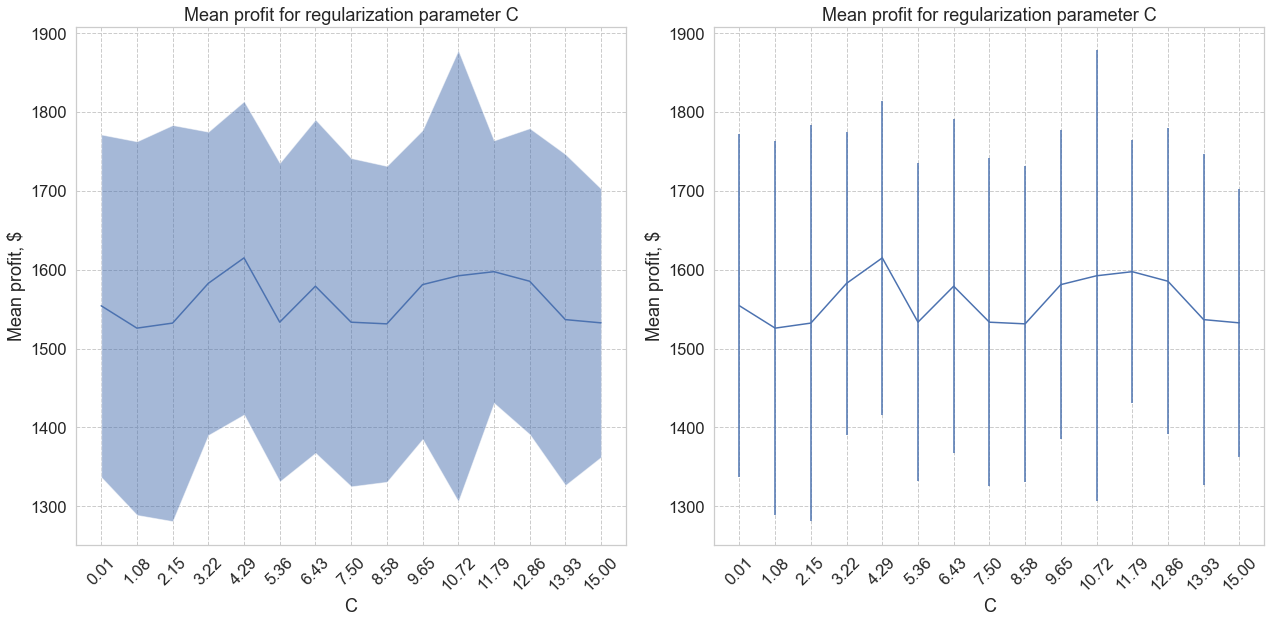

In [66]:
plt.figure(figsize=(18, 9))

# строим первый график
ax1 = plt.subplot(121)
plt.plot(data_for_plot.C, data_for_plot.profit)
ax1.set_xticks(Cs)
plt.xticks(rotation=45)
plt.fill_between(data_for_plot.C, data_for_plot.profit - data_for_plot.error, 
                 data_for_plot.profit + data_for_plot.error, alpha = 0.5)  
plt.xlabel('C')
plt.ylabel('Mean profit, $')
plt.title('Mean profit for regularization parameter C')

# строим второй график
ax2 = plt.subplot(122)
plt.errorbar(data_for_plot.C, data_for_plot.profit, data_for_plot.error)
ax2.set_xticks(Cs)
plt.xticks(rotation=45)
plt.xlabel('C')
plt.ylabel('Mean profit, $')
plt.title('Mean profit for regularization parameter C')

plt.tight_layout()
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Создадим функцию, которая позволит нам провернуть предыдущий трюк несколько раз. Посмотрим, будет ли у нас тот же параметр $С$

In [81]:
def loop_search(X, y, Cs, loops):
    best_profits = []
    best_Cs = []
    for loop in range(loops):
        best_C, best_profit, _ = find_best_C(X, y, Cs)
        best_profits.append(best_profit)
        best_Cs.append(best_C)
    df = pd.DataFrame(data = {'C':best_Cs,
                             'profit':best_profits})
    return df

In [82]:
# ограничимся 5 итерациями, функция выполнятся не так быстро, как бы этого хотелось
results = loop_search(X_new, y, Cs, 5)

In [83]:
results

,C,profit
0,6.434286,1557.180264
1,4.292857,1562.958469
2,9.646429,1576.168889
3,12.858571,1578.788116
4,10.717143,1586.435251


"лучшего" коэффициента нет, но есть закономерность.

Возможно, если бы мы подбирали параметр регуляризации на каких-то зафиксированных данных, то мы бы нашли "лучший" коэффициент, но случайные данные из равномерного распределения на отрезке $[0;20]$ мешают нам адекватно оценивать модель. Случайные данные очень сильно влияют на результаты прибыли. По сути проще крутануть еще раз колесо (аналогия с казино), и получить лучше результат, чем подобрать оптимальный параметр регуляризации. Вероятно, если устремить количество экспериментов к бесконечности можно найти тот самый "лучший" коэффициент. Но до тех пор, пока у всех дома не будет по суперкомпьютеру, мы в этом казино не найдем оптимальный параметр.

Однако несмотря на то, что мы не смогли найти "лучший" коэффициент, мы можем наблюдать приблизительно одинаковое количество прибили при разном параметре $C$. Конечно же такой результат объясняется ЦПТ, которая гласит, что сумма достаточно большого количества слабо зависимых случайных величин, имеющих примерно одинаковые масштабы (а они имеют абсолютно одинаковое распределение), имеет распределение, близкое к нормальному. Таким образом при очень большом количестве экспериментов сумма прибыли имеет распределение, близкое к нормальному.

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Для нашего бизнеса важнее скорее полнота (recall), чем точность (precision). Каждый звонок потенциальному клиенту стоит денег, однако издержки на один звонок очень низки по сравнению с той прибылью, которую потенциальный клиент может нам принести. Поэтому мы хотим обзвонить как можно больше клиентов, для которых мы можем с некоторой вероятностью прогнозировать согласие. Мы можем быть не полностью уверенными в том, что клиент ответит согласием, однако любой потенциальный клиент в среднем принесёт нам выручку в 10 раз больше, чем затраты на одни звонок. В среднем мы начинаем терять прибыль только при условии, что из 10 клиентов, которым мы позвонили, только один ответил согласием.

Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [84]:
from sklearn.metrics import precision_score, recall_score

# Создадим еще одну функцию, которой мы будем пользовать на протяжении этого задания
def find_best_t(X, y, t_net):
    # Создадим переменный с которыми мы будем сравнивать результат 
    best_profit = 0
    best_t = None
    # Создадим датафрейм
    data_for_plot = pd.DataFrame(columns = ['t', 'profit', 'profit_error', 'precision', 
                                            'precision_error', 'recall', 'recall_error'])
    j = 0
    # Начинаем процесс итерации по С
    for t in t_net:
        # Сюда будем записывать результаты прогнозов и таргета на i-м фолде
        y_real = []
        predictions = []
        precisions = []
        recalls = []
        # процесс кросс-валидации
        for train_index, test_index in cv.split(X, y):
            log_reg = LogisticRegression(random_state=777) 
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            log.fit(X_train, y_train)
            prediction = log.predict_proba(X_test)[:, 1]
            precision = precision_score(y_test, prediction >= t)
            recall = recall_score(y_test, prediction >= t)
            # запишем значения
            y_real.append(y_test)
            precisions.append(precision)
            recalls.append(recall)
            predictions.append(prediction >= t)
            
        # этот датафрейм будем использовать для усреднения прибыли на фолде
        revenue = pd.DataFrame(columns = ['profit'])
        # посчитаем прогноз прибыли на каждом фолде
        for i in range(len(predictions)):
            # количество звонков
            salary = sum(predictions[i] == 1)
            # количество успешных звонков
            success_calls = sum((predictions[i] == 1) & (y_real[i] == predictions[i]))
            # расчет выручки
            earnings = 0
            # выручка как и раньше будет у нас случайной 
            for _ in range(success_calls):
                # случайное число из равномерного распределения [0; 20]
                earnings += random.choice(uniform_dist)
            # прибыль
            profit = earnings - salary
            revenue.loc[i] = [profit]
        # посчитаем средний прогноз прибыли при заданном параметре С
        mean_revenue = revenue.agg(['mean', np.std])[['profit']].reset_index()
        mean_profit = mean_revenue.profit[0]
        mean_error = mean_revenue.profit[1]
        # сделаем запись в датафрейм
        data_for_plot.loc[j] = [t, mean_profit, mean_error, np.mean(precisions), np.std(precisions), 
                               np.mean(recalls), np.std(recalls)]
        j += 1
        # сравним средний прогноз прибыли при заданном параметре С с лучшим прогнозом
        if mean_profit > best_profit:
            best_profit = mean_profit
            best_t = t
        
    return best_t, best_profit, data_for_plot

In [85]:
t_net = np.linspace(0, 1, num = 101, endpoint=True)

best_t, best_profit, data_for_plot = find_best_t(X_new, y, t_net)

print('Best profit - {} on level t - {}'.format(best_profit, best_t))

Best profit - 4076.4333420555718 on level t - 0.13


In [86]:
data_for_plot

,t,profit,profit_error,precision,precision_error,recall,recall_error
0,0.00,917.659342,206.077546,0.112654,0.000007,1.000000,0.000000
1,0.01,1020.270493,111.480797,0.112742,0.000180,1.000000,0.000000
2,0.02,1090.632539,157.723297,0.112986,0.000588,0.999353,0.001293
3,0.03,1152.607329,130.717406,0.113900,0.001499,0.993966,0.007729
4,0.04,1734.110296,499.725301,0.127737,0.010847,0.923922,0.046641
...,...,...,...,...,...,...,...
96,0.96,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
97,0.97,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
98,0.98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99,0.99,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

Давайте запустим 3 раза нашу функцию, этого должно хватить, чтобы увидеть закономерность. (Функция очень долго выполняется)

In [87]:
best_t2, best_profit2, data_for_plot2 = find_best_t(X_new, y, t_net)
best_t3, best_profit3, data_for_plot3 = find_best_t(X_new, y, t_net)

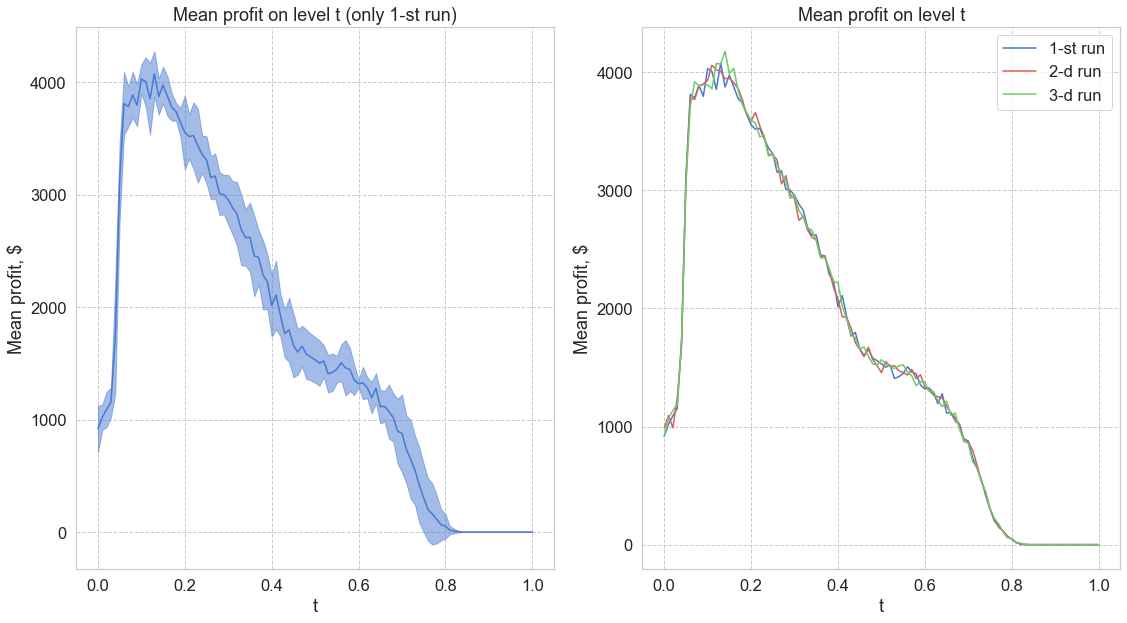

In [88]:
plt.figure(figsize=(16, 9))

ax1 = plt.subplot(121)
plt.plot(data_for_plot.t, data_for_plot.profit, color='b')
plt.fill_between(data_for_plot.t, data_for_plot.profit - data_for_plot.profit_error, 
                 data_for_plot.profit + data_for_plot.profit_error, alpha = 0.5, color='b')  

plt.xlabel('t')
plt.ylabel('Mean profit, $')
plt.title('Mean profit on level t (only 1-st run)')

ax2 = plt.subplot(122)
plt.plot(data_for_plot.t, data_for_plot.profit, color='b', label = '1-st run')

plt.plot(data_for_plot2.t, data_for_plot2.profit, color='r', label = '2-d run')

plt.plot(data_for_plot3.t, data_for_plot3.profit, color='g', label = '3-d run')

plt.xlabel('t')
plt.ylabel('Mean profit, $')
plt.title('Mean profit on level t')
plt.legend()

plt.tight_layout()
plt.show()

Закономерность в наших графиках очевидна, лучшим порогом t для нашей модели данных является промежуток [0.1, 0.2]. Выводы в целом аналогичны ответу, что лучше полнота (recall) или точность (precision). У нас очень низкая себестоимость одного звонка и слишком большая награда за согласие клиента. То есть если мы начнем обзванивать всех клиентов, для которых у нас по нашим данным есть хотя бы уверенность, что с вероятностью в [0.1, 0.2] клиент ответит положительно, такое предположение будет максимизировать прибыль в рамках условий нашей задачи. 

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

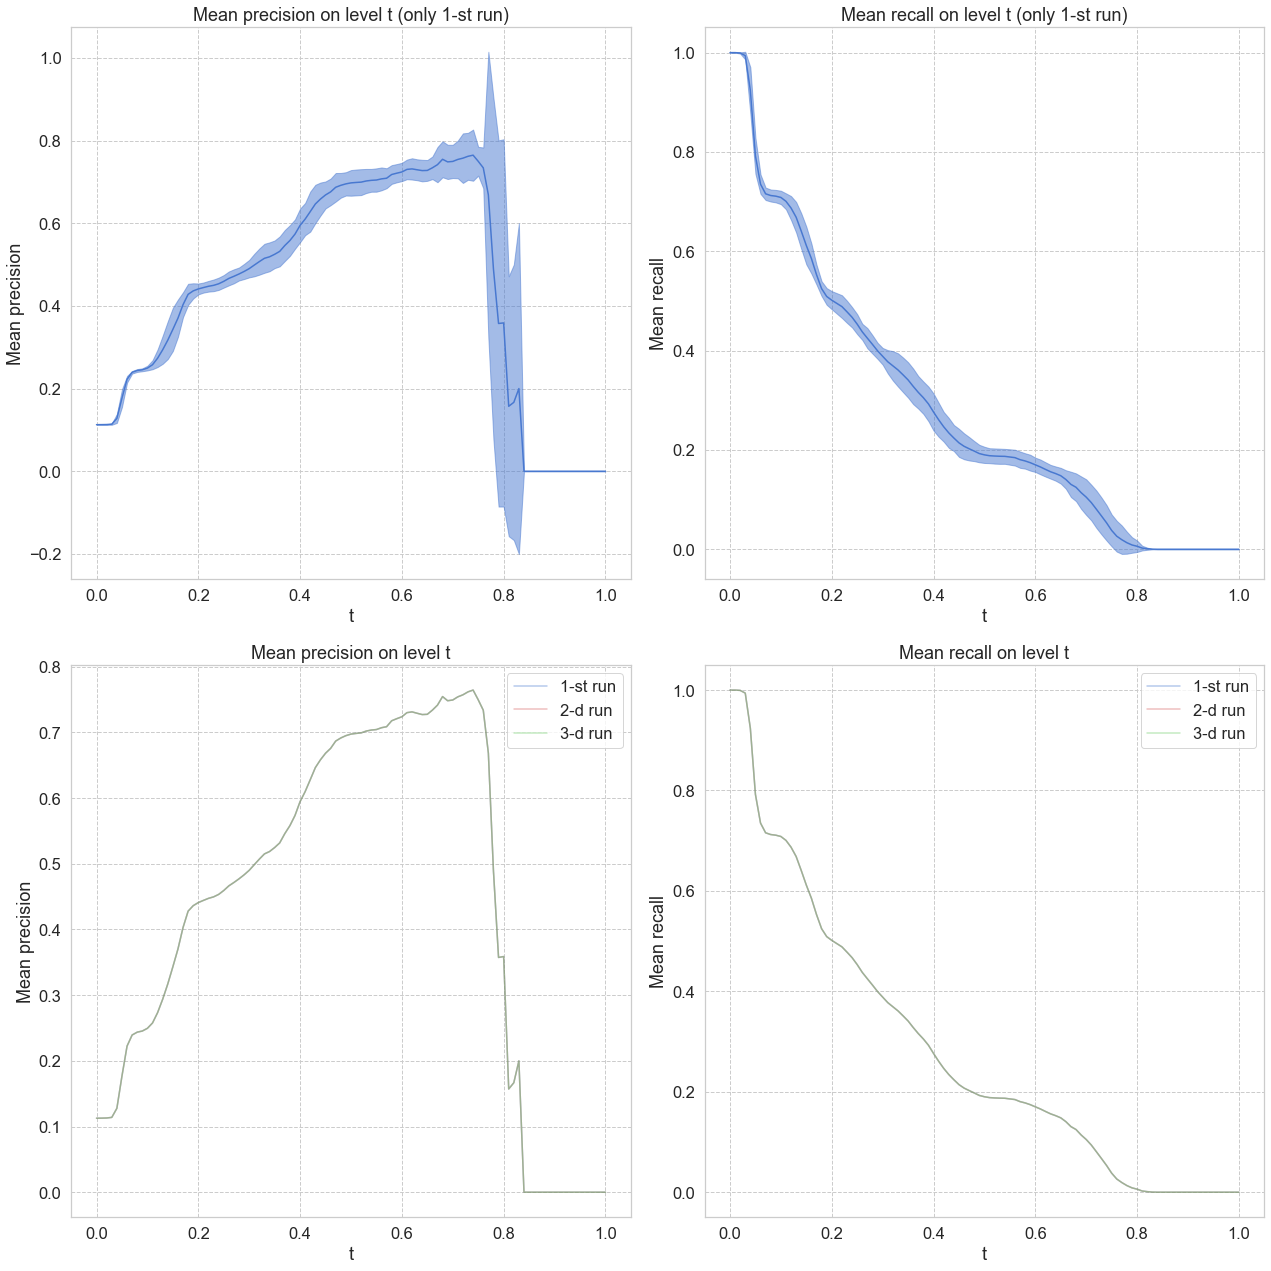

In [89]:
plt.figure(figsize=(18, 18))

ax1 = plt.subplot(221)
plt.plot(data_for_plot.t, data_for_plot.precision, color='b')
plt.fill_between(data_for_plot.t, data_for_plot.precision - data_for_plot.precision_error, 
                 data_for_plot.precision + data_for_plot.precision_error, alpha = 0.5, color='b')

plt.xlabel('t')
plt.ylabel('Mean precision')
plt.title('Mean precision on level t (only 1-st run)')

ax2 = plt.subplot(222)
plt.plot(data_for_plot.t, data_for_plot.recall, color='b')
plt.fill_between(data_for_plot.t, data_for_plot.recall - data_for_plot.recall_error, 
                 data_for_plot.recall + data_for_plot.recall_error, alpha = 0.5, color='b')

plt.xlabel('t')
plt.ylabel('Mean recall')
plt.title('Mean recall on level t (only 1-st run)')

ax3 = plt.subplot(223)
plt.plot(data_for_plot.t, data_for_plot.precision, color='b', label = '1-st run', alpha = 0.4)

plt.plot(data_for_plot2.t, data_for_plot2.precision, color='r', label = '2-d run', alpha = 0.4)

plt.plot(data_for_plot3.t, data_for_plot3.precision, color='g', label = '3-d run', alpha = 0.4)

plt.xlabel('t')
plt.ylabel('Mean precision')
plt.title('Mean precision on level t')
plt.legend()

ax2 = plt.subplot(224)
plt.plot(data_for_plot.t, data_for_plot.recall, color='b', label = '1-st run', alpha = 0.4)

plt.plot(data_for_plot2.t, data_for_plot2.recall, color='r', label = '2-d run', alpha = 0.4)

plt.plot(data_for_plot3.t, data_for_plot3.recall, color='g', label = '3-d run', alpha = 0.4)

plt.xlabel('t')
plt.ylabel('Mean recall')
plt.title('Mean recall on level t')
plt.legend()

plt.tight_layout()
plt.show()

Как можно видеть, графики абсолютно одинаковые (по крайней мере с визуальной стороны)

In [90]:
print('First run:')
print('Best profit - {}'.format(round(best_profit, 2)))
print('Best t - {}'.format(best_t)) 
print('precision - {}, with standard deviation - {}'.format(
    round(data_for_plot.precision[data_for_plot.t == best_t].values[0], 2),
    round(data_for_plot.precision_error[data_for_plot.t == best_t].values[0], 2)))
print('recall - {}, with standard deviation - {}'.format(
    round(data_for_plot.recall[data_for_plot.t == best_t].values[0], 2),
    round(data_for_plot.recall_error[data_for_plot.t == best_t].values[0], 2)))
print('___________________________________________________')
print('Second run:')
print('Best profit - {}'.format(round(best_profit2, 2)))
print('Best t - {}'.format(best_t2)) 
print('precision - {}, with standard deviation - {}'.format(
    round(data_for_plot2.precision[data_for_plot2.t == best_t2].values[0], 2),
    round(data_for_plot2.precision_error[data_for_plot2.t == best_t2].values[0], 2)))
print('recall - {}, with standard deviation - {}'.format(
    round(data_for_plot2.recall[data_for_plot2.t == best_t2].values[0], 2),
    round(data_for_plot2.recall_error[data_for_plot2.t == best_t2].values[0], 2)))
print('___________________________________________________')
print('Third run:')
print('Best profit - {}'.format(round(best_profit3, 2)))
print('Best t - {}'.format(best_t3)) 
print('precision - {}, with standard deviation - {}'.format(
    round(data_for_plot3.precision[data_for_plot3.t == best_t3].values[0], 2),
    round(data_for_plot3.precision_error[data_for_plot3.t == best_t3].values[0], 2)))
print('recall - {}, with standard deviation - {}'.format(
    round(data_for_plot3.recall[data_for_plot3.t == best_t3].values[0], 2),
    round(data_for_plot3.recall_error[data_for_plot3.t == best_t3].values[0], 2)))

First run:
Best profit - 4076.43
Best t - 0.13
precision - 0.29, with standard deviation - 0.03
recall - 0.67, with standard deviation - 0.03
___________________________________________________
Second run:
Best profit - 4058.66
Best t - 0.11
precision - 0.26, with standard deviation - 0.01
recall - 0.7, with standard deviation - 0.02
___________________________________________________
Third run:
Best profit - 4176.7
Best t - 0.14
precision - 0.32, with standard deviation - 0.05
recall - 0.64, with standard deviation - 0.04


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

Поскольку в целом на трех запусках результаты у нас одинаковые, то будем работать, только с первым пробегом.

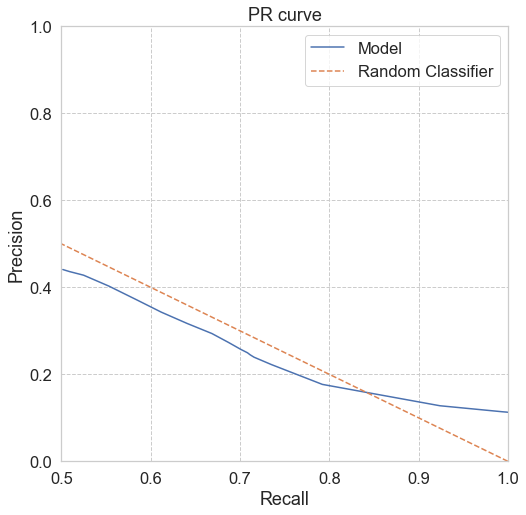

In [93]:
plt.figure(figsize=(8, 8))

pr = data_for_plot['precision']
re = data_for_plot['recall']

plt.plot(re[re>=0.5], pr[re>=0.5], lw = 1.5, label='PR curve')
plt.plot([1, 0], [0, 1], linestyle='--')
plt.xlim([0.5, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(['Model', 'Random Classifier'])

plt.show()

In [94]:
AUC_PR = auc(re[re>=0.5], pr[re>=0.5]) / 0.5 # считаем площадь только на половине
print('{} - AUC_PR score for our model where recall > 0.5'.format(round(AUC_PR, 5)))

0.23901 - AUC_PR score for our model where recall > 0.5


AUC-PR небольшой, однако он не является нашей целевой метрикой качества. Все-таки наша главная задача — это максимизация прибыли. Поэтому иногда бывает, что наша модель не оптимальна с точки зрения некоторых метрик, зато она идеально (почти) соответствует нашей бизнес задаче.

Ссылки на источники вселенского познания:
- https://habr.com/ru/company/ods/blog/328372/
- https://github.com/esokolov/ml-course-hse/blob/master/2018-fall/seminars/sem07-trees.ipynb
- https://codengineering.ru/post/23198
- https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression
- https://gist.github.com/marnixkoops/e68815d30474786e2b293682ed7cdb01
- https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
- http://zabaykin.ru/?p=667